In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import time

In [ ]:
# Parameters
type_ngd = 'IND'   #choose between 'NGD', 'LDZ', 'GTP', 'IND'
# Model Parameters
test_ratio = 0.1
timesteps =30
nr_lastdays = 30
svm_c = 100

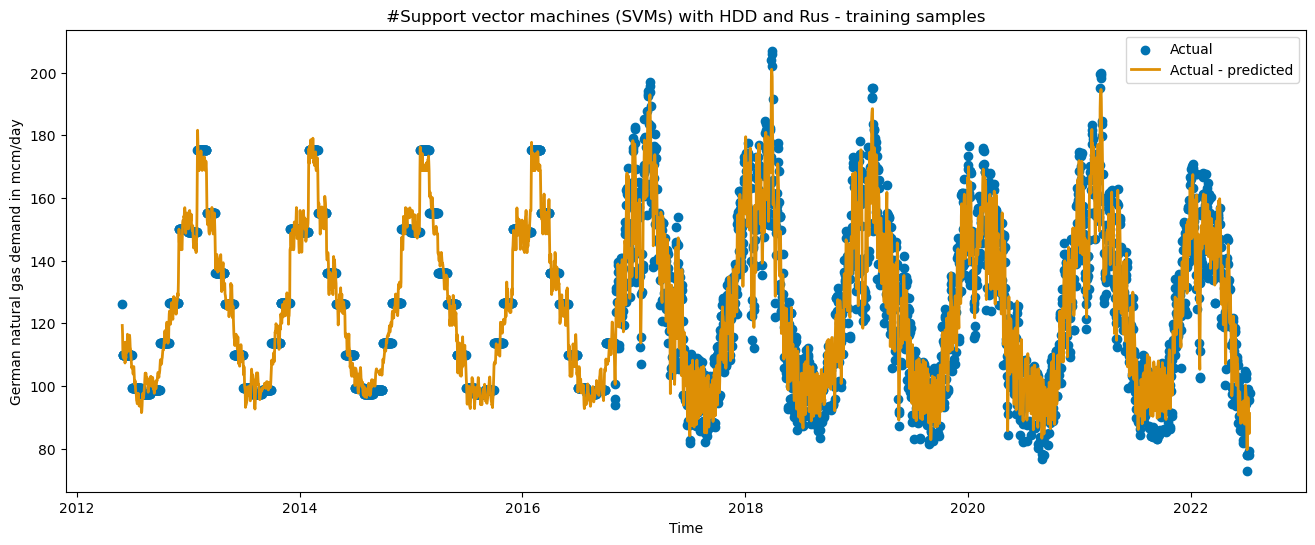

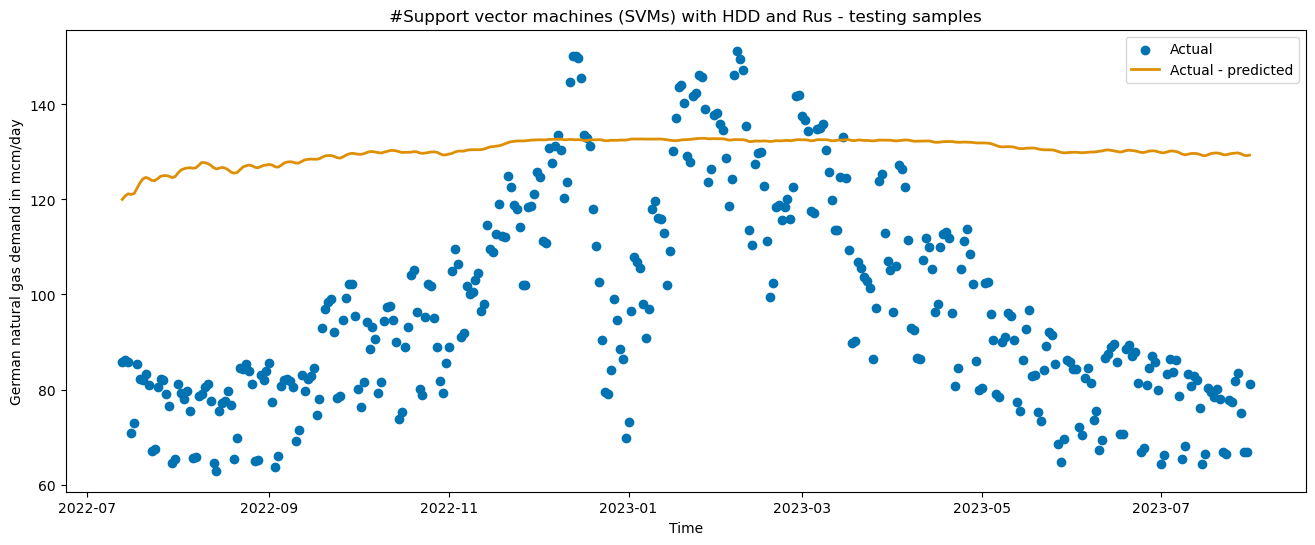

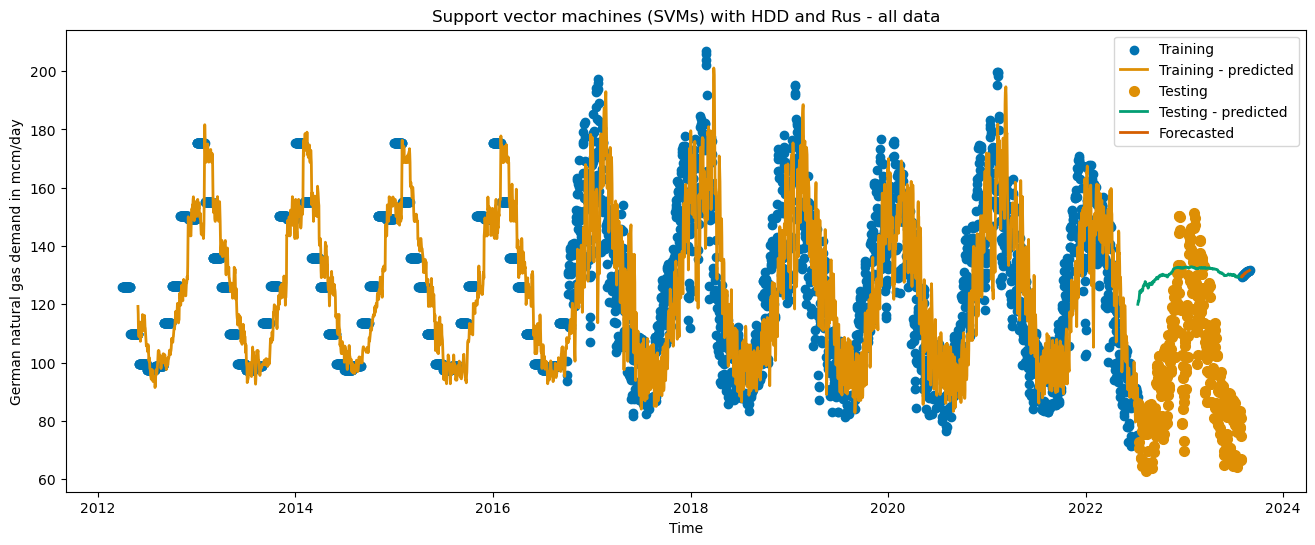

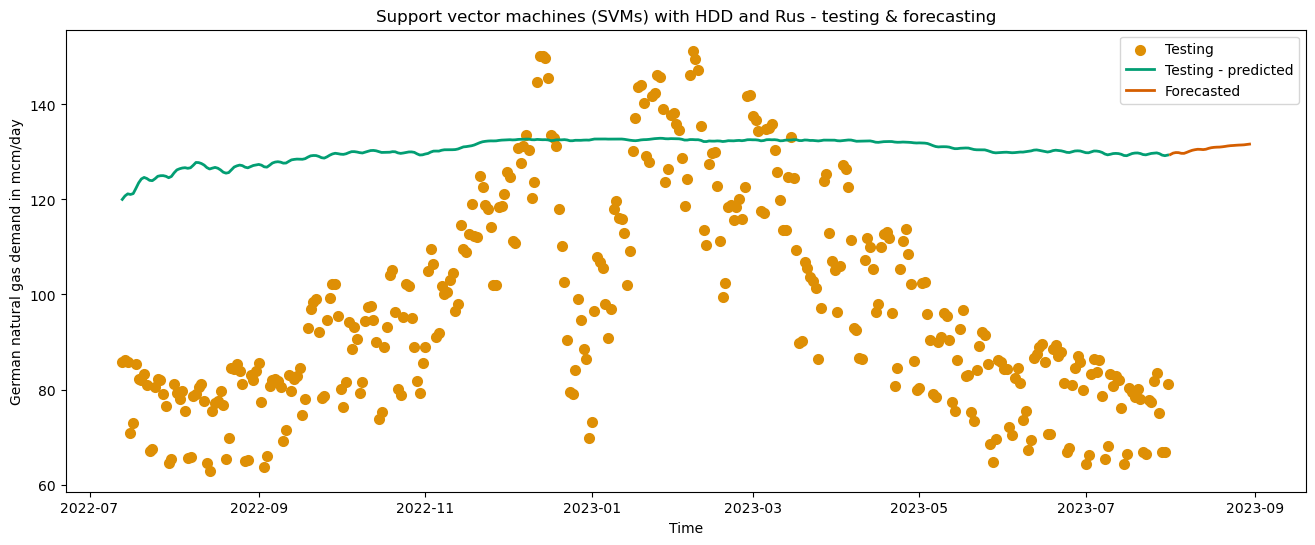

Execution Time for IND - Prophet with HDD and Rus: 0.91 seconds
Evluation SVM with HDD and Rus
Training RMSE: 4.3573
Testing RMSE: 38.7369
Training R2 score: 0.9715
Testing R2 score: -2.1216
Training MAE: 3.7322
Testing MAE: 34.4221


In [ ]:
#SVM with HDD and Rus
import pandas as pd
import numpy as np
import datetime
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
import time  # Importing the time module


ngd_data = pd.read_csv('daily_NGD.csv', delimiter=';')

# set train and test start dates
train_start_date = ngd_data.loc[ngd_data[type_ngd].notnull(), 'Date'].iloc[0]
train_start_dt = ngd_data[ngd_data['Date'] == train_start_date].index[0]
test_start_dt = round(len(ngd_data)*(1-test_ratio))+1

# set train and test data
train = ngd_data[(ngd_data.index >= train_start_dt) & (ngd_data.index < test_start_dt)][[type_ngd, "HDD", "Rus"]].dropna()
test = ngd_data[ngd_data.index >= test_start_dt][[type_ngd, "HDD", "Rus"]].dropna()


# Separate scalers for HDD and NGD
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()
rus_scaler = MinMaxScaler()

train['HDD'] = input_scaler.fit_transform(train[['HDD']])
test['HDD'] = input_scaler.transform(test[['HDD']])
train['Rus'] = rus_scaler.fit_transform(train[['Rus']])
test['Rus'] = rus_scaler.transform(test[['Rus']])
train[type_ngd] = output_scaler.fit_transform(train[[type_ngd]])
test[type_ngd] = output_scaler.transform(test[[type_ngd]])

# Converting to numpy arrays
train_data = train.values
test_data = test.values

train_data_timesteps = np.array([[j for j in train_data[i:i+timesteps]] for i in range(0, len(train_data)-timesteps+1)])
test_data_timesteps = np.array([[j for j in test_data[i:i+timesteps]] for i in range(0, len(test_data)-timesteps+1)])

x_train, y_train = train_data_timesteps[:,:timesteps-1,:], train_data_timesteps[:,[timesteps-1], 0]
x_test, y_test = test_data_timesteps[:,:timesteps-1,:], test_data_timesteps[:,[timesteps-1], 0]

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

start_time = time.time()  # Starting the timer
model = svm.SVR(kernel='rbf', gamma=0.5, C=svm_c, epsilon=0.05)
model.fit(x_train, y_train.ravel())
y_train_pred = model.predict(x_train).reshape(-1, 1)
y_test_pred = model.predict(x_test).reshape(-1, 1)

# Scaling the predictions
y_train_pred = output_scaler.inverse_transform(y_train_pred)
y_test_pred = output_scaler.inverse_transform(y_test_pred)

#y_train_pred = scaler.inverse_transform(np.hstack((y_train_pred, np.zeros_like(y_train_pred))))[:, 0].reshape(-1, 1)
#y_test_pred = scaler.inverse_transform(np.hstack((y_test_pred, np.zeros_like(y_test_pred))))[:, 0].reshape(-1, 1)

# Scaling the original values
y_train = output_scaler.inverse_transform(y_train)
y_test = output_scaler.inverse_transform(y_test)

# Forecasting 
last_days = ngd_data.loc[:, [type_ngd, 'HDD', 'Rus']].dropna().tail(nr_lastdays).copy()

# Scale the data using the same MinMaxScalers used for training data
last_days['HDD'] = input_scaler.transform(last_days[['HDD']])
last_days[type_ngd] = output_scaler.transform(last_days[[type_ngd]])
last_days['Rus'] = rus_scaler.transform(last_days[['Rus']])

# Create a list to store the forecasted values
forecast = [] 

for i in range(nr_lastdays):
    # Take the last `nr_lastdays - 1` data (which includes HDD and the gas demand) and reshape it to a 2D numpy array
    input_data = last_days[-(nr_lastdays-1):].values.reshape((nr_lastdays-1), 3)

    # Flatten and use the model to make a forecast for the next day
    forecast_value = model.predict(input_data.reshape(1, -1))
    
    # Append the forecasted value to the list of forecasts
    forecast.append(forecast_value)
    
    # Create a new entry with the forecasted value, the next day's HDD, and the last known Rus value
    new_entry = np.array([forecast_value[0], last_days.iloc[-1]['HDD'], last_days.iloc[-1]['Rus']])
    
    # Update last_days with the new entry
    last_days = pd.concat([last_days, pd.DataFrame([new_entry], columns=last_days.columns)])

# Rescale only the forecasted values for gas demand
forecast_nextdays = output_scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Print the forecasted values
#print(forecast_nextdays)

train_timestamps = ngd_data.copy()[(ngd_data.index >= train_start_dt+(timesteps-1)*2) & (ngd_data.index < test_start_dt+(timesteps-1))][['Date']]
test_timestamps = ngd_data.copy().iloc[test_start_dt+(timesteps-1):test_start_dt+(timesteps-1)+len(y_test)][['Date']]

colors = sns.color_palette("colorblind")

plt.figure(figsize=(16, 6))
plt.scatter(pd.to_datetime(train_timestamps['Date'], format='%Y/%m/%d'), y_train, color=colors[0], label="Actual")
plt.plot(pd.to_datetime(train_timestamps['Date'], format='%Y/%m/%d'), y_train_pred, color=colors[1], label="Actual - predicted", linewidth=2)
plt.xlabel("Time")
plt.ylabel("German natural gas demand in mcm/day")
plt.title(" #Support vector machines (SVMs) with HDD and Rus - training samples ")
plt.legend()
plt.show()

# Create a new DataFrame with test dates, actual values, and predicted values
test_results = pd.DataFrame({
    'Date': test_timestamps['Date'],
    'Actual': y_test.flatten(),
    'Predicted': y_test_pred.flatten()
})

# Drop any rows containing NaN values
test_results = test_results.dropna()

plt.figure(figsize=(16, 6))
plt.scatter(pd.to_datetime(test_results['Date'], format='%Y/%m/%d'), test_results['Actual'], color=colors[0], label="Actual")
plt.plot(pd.to_datetime(test_results['Date'], format='%Y/%m/%d'), test_results['Predicted'], color=colors[1], label="Actual - predicted", linewidth=2)
plt.xlabel("Time")
plt.ylabel("German natural gas demand in mcm/day")
plt.title(" #Support vector machines (SVMs) with HDD and Rus - testing samples ")
plt.legend()
plt.show()

# Concatenate the training and testing data, and add the predicted values for the next 30 days
all_data = np.concatenate((np.array(ngd_data.loc[:, type_ngd].values).reshape(-1,1), forecast_nextdays))

# Create a list of timestamps for all the data points
all_timestamps = ngd_data.copy()[['Date']]

last_date = all_timestamps.loc[all_timestamps['Date'].notnull(), 'Date'].iloc[-1]
next_start_date = pd.to_datetime(last_date, format='%Y/%m/%d') + pd.Timedelta(days=1)
nextdays_dates = pd.date_range(next_start_date, periods=nr_lastdays, freq='D')
nextdays_timestamps = pd.DataFrame({'Date': nextdays_dates.strftime('%Y/%m/%d')})
all_timestamps = pd.concat([all_timestamps, nextdays_timestamps])

# Create a scatter plot of all the data points
plt.figure(figsize=(16, 6))
plt.scatter(pd.to_datetime(all_timestamps['Date'], format='%Y/%m/%d'), all_data, color=colors[0], label="Training")
plt.plot(pd.to_datetime(train_timestamps['Date'], format='%Y/%m/%d'), y_train_pred, color=colors[1], label="Training - predicted", linewidth=2)
plt.scatter(pd.to_datetime(test_timestamps['Date'], format='%Y/%m/%d'), y_test, color=colors[1], label="Testing", linewidth=2)
plt.plot(pd.to_datetime(test_timestamps['Date'], format='%Y/%m/%d'), y_test_pred, color=colors[2], label="Testing - predicted", linewidth=2)
plt.plot(nextdays_dates, forecast_nextdays, color=colors[3], label="Forecasted", linewidth=2)
plt.xlabel("Time")
plt.ylabel("German natural gas demand in mcm/day")
plt.title("Support vector machines (SVMs) with HDD and Rus - all data")
plt.legend()
plt.show()

# Create a scatter plot of testing and forecasting
plt.figure(figsize=(16, 6))
plt.scatter(pd.to_datetime(test_timestamps['Date'], format='%Y/%m/%d'), y_test, color=colors[1], label="Testing", linewidth=2)
plt.plot(pd.to_datetime(test_timestamps['Date'], format='%Y/%m/%d'), y_test_pred, color=colors[2], label="Testing - predicted", linewidth=2)
plt.plot(nextdays_dates, forecast_nextdays, color=colors[3], label="Forecasted", linewidth=2)
plt.xlabel("Time")
plt.ylabel("German natural gas demand in mcm/day")
plt.title("Support vector machines (SVMs) with HDD and Rus - testing & forecasting")
plt.legend()
plt.show()

end_time = time.time()  # Ending the timer
print(f"Execution Time for {type_ngd} - SVM with HDD and Rus: {end_time - start_time:.2f} seconds")

# Calculate evaluation metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Evluation SVM with HDD and Rus")
print("Training RMSE: {:.4f}".format(train_rmse))
print("Testing RMSE: {:.4f}".format(test_rmse))
print("Training R2 score: {:.4f}".format(train_r2))
print("Testing R2 score: {:.4f}".format(test_r2))
print("Training MAE: {:.4f}".format(train_mae))
print("Testing MAE: {:.4f}".format(test_mae))

